In [1]:
!make docker-image > /dev/null 2>&1

In [2]:
!CONTAINER_CMD="bash -lc 'make install-ycsb" make docker > /dev/null 2>&1

In [3]:
from pathlib import Path
import pexpect
import os
import time

""" Collector class has helper methods to interact with kermit"""
class Collector: 
    def __init__(self, config: Path):
        self.env = os.environ.copy()
        self.env["INTERACTIVE"] = "it"
        self.env["CONTAINER_CMD"] = f"bash -lc 'KERNMLOPS_CONFIG_FILE={config} make collect-data'"
        self.collect_process : pexpect.spawn | None = None

    def start_collection(self, logfile=None):
        self.collect_process = pexpect.spawn("make docker", env=self.env, timeout=None, logfile=logfile)
        self.collect_process.expect_exact(["Started benchmark"])

    def _after_run_generate_file_data() -> dict[str, list[Path]]:
        start_path : Path = Path("./data")
        list_of_collect_id_dirs = start_path.glob("*/*/*")
        latest_collect_id = max(list_of_collect_id_dirs, key=os.path.getctime)
        list_of_files = latest_collect_id.glob("*.*.parquet")
        output = {}
        for f in list_of_files:
            index = str(f).removeprefix(str(f.parent) + "/").split(".")[0]
            if index not in output.keys():
                output[index] = []
            output[index].append(f)
        return output
        
    def wait(self) -> int:
        if self.collect_process is None:
            return
        self.collect_process.expect([pexpect.EOF])
        self.collect_process.wait()
        return Collector._after_run_generate_file_data()
        
    def stop_collection(self):
        if self.collect_process is None:
            return
        self.collect_process.sendline("END")
        return self.wait()

There are two ways to run kermit:
- With the raw config
- With a pre-programmed benchmark config

In [4]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Optional
import warnings
warnings.filterwarnings('ignore')

def analyze_tcp_hooks(data: Dict, workload_name: str = "Workload"):
    """
    Comprehensive analysis of TCP behavior from all three hooks.
    Properly calculates distributions using entry count as denominator.
    """
    
    print(f"\n{'='*80}")
    print(f"TCP ANALYSIS: {workload_name.upper()}")
    print(f"{'='*80}")
    
    # Load data safely from all three hooks
    tcp_rcv_df = None
    tcp_state_df = None  
    tcp_connect_df = None
    tcp_cc_df = None
    
    if "tcp_v4_rcv" in data and len(data["tcp_v4_rcv"]) > 0:
        tcp_rcv_df = pl.read_parquet(data["tcp_v4_rcv"][0])
        print(f"✓ Loaded tcp_v4_rcv: {len(tcp_rcv_df):,} events")
    else:
        print("✗ No tcp_v4_rcv data")
    
    if "tcp_state_process" in data and len(data["tcp_state_process"]) > 0:
        tcp_state_df = pl.read_parquet(data["tcp_state_process"][0])
        print(f"✓ Loaded tcp_state_process: {len(tcp_state_df):,} events")
    else:
        print("✗ No tcp_state_process data")
    
    if "tcp_v4_connect" in data and len(data["tcp_v4_connect"]) > 0:
        tcp_connect_df = pl.read_parquet(data["tcp_v4_connect"][0])
        print(f"✓ Loaded tcp_v4_connect: {len(tcp_connect_df):,} events")
    else:
        print("✗ No tcp_v4_connect data")

    if "tcp_congestion_control" in data and len(data["tcp_congestion_control"]) > 0:
        tcp_cc_df = pl.read_parquet(data["tcp_congestion_control"][0])
        print(f"✓ Loaded tcp_congestion_control: {len(tcp_cc_df):,} events")
    else:
        print("✗ No tcp_congestion_control data")
    
    # =========================================================================
    # 1. TCP v4 Receive Analysis (Packet Processing)
    # =========================================================================
    if tcp_rcv_df is not None and len(tcp_rcv_df) > 0:
        print(f"\n[1] TCP PACKET RECEIVE (tcp_v4_rcv)")
        print("-" * 40)
        
        # CRITICAL: Use entry count as denominator
        entry_count = len(tcp_rcv_df.filter(pl.col("branch_name") == "entry"))
        print(f"Packets received (entry events): {entry_count:,}")
        print(f"Total events recorded: {len(tcp_rcv_df):,}")
        print(f"Events per packet: {len(tcp_rcv_df)/entry_count:.2f}" if entry_count > 0 else "N/A")
        
        if entry_count > 0:
            # Calculate branch distribution with entry as denominator
            print(f"\nBranch Distribution (% of packets):")
            branch_dist = tcp_rcv_df.group_by("branch_name").agg([
                pl.count().alias("count")
            ]).with_columns([
                (pl.col("count") * 100.0 / entry_count).alias("pct_of_packets"),
                (pl.col("count") * 100.0 / len(tcp_rcv_df)).alias("pct_of_events")
            ]).sort("count", descending=True)
            
            for row in branch_dist.head(10).iter_rows():
                branch, count, pct_packets, pct_events = row
                # Show both percentages for clarity
                print(f"  {branch:20s}: {count:6d} ({pct_packets:5.1f}% of packets)")
            
            # Performance metrics
            print(f"\nPerformance Metrics:")
            
            # Fast path (direct processing)
            fast_path = ["do_rcv_direct", "established_proc"]
            fast_count = len(tcp_rcv_df.filter(pl.col("branch_name").is_in(fast_path)))
            print(f"  Fast path: {fast_count:,} ({fast_count/entry_count*100:.1f}% of packets)")
            
            # Slow path (backlog)
            slow_path = ["socket_busy", "backlog_add"]
            slow_count = len(tcp_rcv_df.filter(pl.col("branch_name").is_in(slow_path)))
            print(f"  Slow path: {slow_count:,} ({slow_count/entry_count*100:.1f}% of packets)")
            
            # Listen processing
            listen_count = len(tcp_rcv_df.filter(pl.col("branch_name") == "listen_state"))
            print(f"  Listen state: {listen_count:,} ({listen_count/entry_count*100:.1f}% of packets)")
            
            # Drops
            drops = tcp_rcv_df.filter(pl.col("drop_reason") > 0)
            if len(drops) > 0:
                drop_rate = len(drops) / entry_count * 100
                print(f"  Dropped: {len(drops):,} ({drop_rate:.2f}% drop rate)")
                
                print(f"\n  Drop Reasons:")
                drop_dist = drops.group_by("drop_reason_name").count().sort("count", descending=True)
                for row in drop_dist.iter_rows():
                    print(f"    {row[0]:20s}: {row[1]:4d}")
            else:
                print(f"  ✓ No packet drops")
            
            # Process breakdown
            print(f"\nTop Processes:")
            proc_dist = tcp_rcv_df.filter(pl.col("branch_name") == "entry").group_by("comm").count().sort("count", descending=True)
            for row in proc_dist.head(5).iter_rows():
                print(f"  {row[0]:20s}: {row[1]:6d} packets")
    
    # =========================================================================
    # 2. TCP State Process Analysis (State Machine)
    # =========================================================================
    if tcp_state_df is not None and len(tcp_state_df) > 0:
        print(f"\n[2] TCP STATE MACHINE (tcp_state_process)")
        print("-" * 40)
        
        # Event type breakdown
        event_dist = tcp_state_df.group_by("event_type_name").count().sort("count", descending=True)
        print(f"Event Types:")
        for row in event_dist.iter_rows():
            print(f"  {row[0]:15s}: {row[1]:6d}")
        
        # State transitions
        transitions = tcp_state_df.filter(pl.col("event_type_name") == "TRANSITION")
        if len(transitions) > 0:
            print(f"\nState Transitions: {len(transitions):,}")
            
            # Create transition strings
            trans_summary = transitions.select([
                pl.concat_str([
                    pl.col("old_state_name"),
                    pl.lit(" → "),
                    pl.col("new_state_name")
                ]).alias("transition")
            ]).group_by("transition").count().sort("count", descending=True)
            
            print(f"Top Transitions:")
            for row in trans_summary.head(10).iter_rows():
                print(f"  {row[0]:35s}: {row[1]:4d}")
            
            # Connection lifecycle analysis
            print(f"\nConnection Lifecycle:")
            
            # New connections
            new_conn = len(transitions.filter(
                (pl.col("old_state_name") == "LISTEN") & 
                (pl.col("new_state_name") == "SYN_RECV")
            ))
            
            # Established
            established = len(transitions.filter(pl.col("new_state_name") == "ESTABLISHED"))
            
            # Terminating
            fin_wait = len(transitions.filter(pl.col("new_state_name").str.contains("FIN_WAIT")))
            time_wait = len(transitions.filter(pl.col("new_state_name") == "TIME_WAIT"))
            closed = len(transitions.filter(pl.col("new_state_name").str.contains("CLOSE")))
            
            print(f"  New connections: {new_conn}")
            print(f"  Established: {established}")
            print(f"  FIN_WAIT: {fin_wait}")
            print(f"  TIME_WAIT: {time_wait}")
            print(f"  Closed: {closed}")
            
            # Connection health check
            if established > 0:
                proper_close = (time_wait + closed) / established * 100
                print(f"  Connection closure rate: {proper_close:.1f}%")
                if proper_close < 80:
                    print(f"  ⚠ Possible connection leak")
    
    # =========================================================================
    # 3. TCP v4 Connect Analysis (Connection Establishment)
    # =========================================================================
    if tcp_connect_df is not None and len(tcp_connect_df) > 0:
        print(f"\n[3] TCP CONNECTION ESTABLISHMENT (tcp_v4_connect)")
        print("-" * 40)
        
        # CRITICAL: Use entry count as denominator
        if "branch_name" in tcp_connect_df.columns:
            entry_count = len(tcp_connect_df.filter(pl.col("branch_name") == "entry"))
            print(f"Connection attempts (entry events): {entry_count:,}")
            print(f"Total events recorded: {len(tcp_connect_df):,}")
            
            if entry_count > 0:
                # Branch distribution
                print(f"\nBranch Distribution (% of attempts):")
                branch_dist = tcp_connect_df.group_by("branch_name").agg([
                    pl.count().alias("count")
                ]).with_columns([
                    (pl.col("count") * 100.0 / entry_count).alias("pct_of_attempts")
                ]).sort("count", descending=True)
                
                for row in branch_dist.head(10).iter_rows():
                    branch, count, pct = row
                    print(f"  {branch:20s}: {count:6d} ({pct:5.1f}% of attempts)")
                
                # Path analysis
                if "path_name" in tcp_connect_df.columns:
                    print(f"\nConnection Paths:")
                    path_dist = tcp_connect_df.group_by("path_name").count().sort("count", descending=True)
                    for row in path_dist.iter_rows():
                        print(f"  {row[0]:15s}: {row[1]:6d}")
                
                # Success/failure analysis
                if "error_code" in tcp_connect_df.columns:
                    success = len(tcp_connect_df.filter(pl.col("error_code") == 0))
                    failed = len(tcp_connect_df.filter(pl.col("error_code") != 0))
                    
                    print(f"\nConnection Results:")
                    print(f"  Successful: {success:,} ({success/entry_count*100:.1f}% success rate)")
                    print(f"  Failed: {failed:,} ({failed/entry_count*100:.1f}% failure rate)")
                    
                    if failed > 0:
                        print(f"\n  Failure Reasons:")
                        error_dist = tcp_connect_df.filter(pl.col("error_code") != 0).group_by("error_name").count().sort("count", descending=True)
                        for row in error_dist.head(5).iter_rows():
                            print(f"    {row[0]:20s}: {row[1]:4d}")
                
                # Latency analysis
                if "latency_ns" in tcp_connect_df.columns:
                    latencies = tcp_connect_df.filter(pl.col("latency_ns") > 0)["latency_ns"]
                    if len(latencies) > 0:
                        print(f"\nConnection Latency:")
                        print(f"  Average: {latencies.mean()/1000:.1f} μs")
                        print(f"  Median: {latencies.median()/1000:.1f} μs")
                        print(f"  P95: {latencies.quantile(0.95)/1000:.1f} μs")
                        print(f"  P99: {latencies.quantile(0.99)/1000:.1f} μs")
                        print(f"  Max: {latencies.max()/1000:.1f} μs")
    # =========================================================================
    # 4. TCP Congestion Control Analysis
    # =========================================================================
    if tcp_cc_df is not None and len(tcp_cc_df) > 0:
        print(f"[4] TCP CONGESTION CONTROL (tcp_congestion_control)")
        print("-" * 40)

        event_dist = tcp_cc_df.group_by("event_type_name").count().sort("count", descending=True)
        print("Event Types:")
        for row in event_dist.iter_rows():
            print(f"  {row[0]:10s}: {row[1]:6d}")

        algo_dist = tcp_cc_df.group_by("ca_name").count().sort("count", descending=True)
        print("Congestion Algorithms:")
        for row in algo_dist.iter_rows():
            print(f"  {row[0]:15s}: {row[1]:6d}")

        if len(algo_dist) > 0:
            fig, ax = plt.subplots(figsize=(6,3))
            ax.bar(algo_dist["ca_name"], algo_dist["count"])
            ax.set_ylabel("Events")
            ax.set_title("Congestion control algorithms")
            ax.tick_params(axis='x', rotation=45)
            plt.tight_layout()
            plt.show()
    
    # =========================================================================
    # 4. Cross-Hook Correlation Analysis
    # =========================================================================
    print(f"\n[5] CROSS-HOOK ANALYSIS")
    print("-" * 40)
    
    # Calculate overall health score
    health_score = 100
    issues = []
    
    if tcp_rcv_df is not None and len(tcp_rcv_df) > 0:
        entry_count = len(tcp_rcv_df.filter(pl.col("branch_name") == "entry"))
        if entry_count > 0:
            # Check for drops
            drops = len(tcp_rcv_df.filter(pl.col("drop_reason") > 0))
            if drops > 0:
                drop_rate = drops / entry_count * 100
                health_score -= min(20, drop_rate * 10)
                issues.append(f"Packet drops: {drop_rate:.2f}%")
            
            # Check for backlog pressure
            slow_count = len(tcp_rcv_df.filter(pl.col("branch_name").is_in(["socket_busy", "backlog_add"])))
            if slow_count > entry_count * 0.1:
                health_score -= 10
                issues.append(f"High backlog: {slow_count/entry_count*100:.1f}%")
    
    if tcp_connect_df is not None and "error_code" in tcp_connect_df.columns:
        entry_count = len(tcp_connect_df.filter(pl.col("branch_name") == "entry")) if "branch_name" in tcp_connect_df.columns else len(tcp_connect_df)
        if entry_count > 0:
            failures = len(tcp_connect_df.filter(pl.col("error_code") != 0))
            if failures > 0:
                fail_rate = failures / entry_count * 100
                health_score -= min(20, fail_rate * 5)
                issues.append(f"Connection failures: {fail_rate:.1f}%")
    
    print(f"Overall Health Score: {max(0, health_score)}/100")
    if issues:
        print(f"Issues Found:")
        for issue in issues:
            print(f"  • {issue}")
    else:
        print(f"✓ No significant issues detected")
    
    # Performance recommendations
    print(f"\nRecommendations:")
    if tcp_rcv_df is not None:
        entry_count = len(tcp_rcv_df.filter(pl.col("branch_name") == "entry"))
        if entry_count > 0:
            slow_count = len(tcp_rcv_df.filter(pl.col("branch_name").is_in(["socket_busy", "backlog_add"])))
            if slow_count > entry_count * 0.1:
                print(f"  • Increase socket buffer: sysctl -w net.core.rmem_max=134217728")
            
            drops = len(tcp_rcv_df.filter(pl.col("drop_reason") > 0))
            if drops > 0:
                print(f"  • Check network interface: ethtool -S <interface>")
                print(f"  • Review firewall rules: iptables -L -n -v")
    
    if tcp_connect_df is not None and "error_code" in tcp_connect_df.columns:
        failures = tcp_connect_df.filter(pl.col("error_code") != 0)
        if len(failures) > 0:
            if "ENETUNREACH" in failures["error_name"].to_list() if "error_name" in failures.columns else []:
                print(f"  • Check routing: ip route show")
            if "EADDRINUSE" in failures["error_name"].to_list() if "error_name" in failures.columns else []:
                print(f"  • Check port usage: ss -tulpn")
    
    return {
        "tcp_rcv_df": tcp_rcv_df,
        "tcp_state_df": tcp_state_df,
        "tcp_connect_df": tcp_connect_df,
        "health_score": health_score,
        "issues": issues
    }

In [5]:
import subprocess
import sys


# New TCP Collector
collect = Collector("./config/raw_overrides.yaml")
collect.start_collection()

# Generate some TCP traffic
!nc -l 8080 &  # Listen on port 8080
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 

data = collect.stop_collection()

In [6]:
data

{'tcp_v4_connect': [PosixPath('data/curated/faux/798c2495-6a27-4c4c-a6e8-a43fb9011e42/tcp_v4_connect.end.parquet')],
 'system_info': [PosixPath('data/curated/faux/798c2495-6a27-4c4c-a6e8-a43fb9011e42/system_info.end.parquet')],
 'tcp_v4_rcv': [PosixPath('data/curated/faux/798c2495-6a27-4c4c-a6e8-a43fb9011e42/tcp_v4_rcv.end.parquet')],
 'tcp_state_process': [PosixPath('data/curated/faux/798c2495-6a27-4c4c-a6e8-a43fb9011e42/tcp_state_process.end.parquet')],
 'tcp_cubic': [PosixPath('data/curated/faux/798c2495-6a27-4c4c-a6e8-a43fb9011e42/tcp_cubic.end.parquet')],
 'tcp_congestion_control': [PosixPath('data/curated/faux/798c2495-6a27-4c4c-a6e8-a43fb9011e42/tcp_congestion_control.end.parquet')]}


TCP ANALYSIS: NETCAT (NC)
✓ Loaded tcp_v4_rcv: 4,886 events
✓ Loaded tcp_state_process: 123 events
✓ Loaded tcp_v4_connect: 96 events
✓ Loaded tcp_congestion_control: 34 events

[1] TCP PACKET RECEIVE (tcp_v4_rcv)
----------------------------------------
Packets received (entry events): 1,165
Total events recorded: 4,886
Events per packet: 4.19

Branch Distribution (% of packets):
  entry               :   1165 (100.0% of packets)
  time_wait           :   1148 ( 98.5% of packets)
  new_syn_recv        :   1148 ( 98.5% of packets)
  established_proc    :   1130 ( 97.0% of packets)
  socket_busy         :    241 ( 20.7% of packets)
  listen_state        :     19 (  1.6% of packets)
  do_rcv_direct       :     18 (  1.5% of packets)
  no_socket           :     17 (  1.5% of packets)

Performance Metrics:
  Fast path: 1,148 (98.5% of packets)
  Slow path: 241 (20.7% of packets)
  Listen state: 19 (1.6% of packets)
  Dropped: 17 (1.46% drop rate)

  Drop Reasons:
    no_socket           :

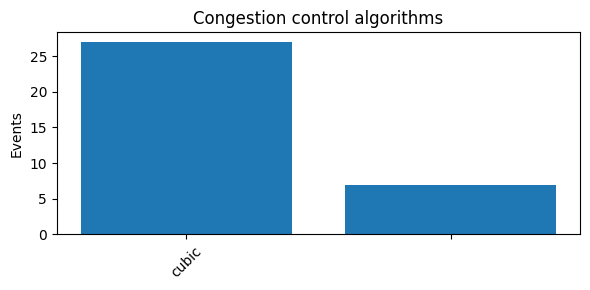


[5] CROSS-HOOK ANALYSIS
----------------------------------------
Overall Health Score: 55.40772532188841/100
Issues Found:
  • Packet drops: 1.46%
  • High backlog: 20.7%
  • Connection failures: 900.0%

Recommendations:
  • Increase socket buffer: sysctl -w net.core.rmem_max=134217728
  • Check network interface: ethtool -S <interface>
  • Review firewall rules: iptables -L -n -v


In [7]:
nc_data = analyze_tcp_hooks(data, "Netcat (nc)")

In [8]:
# Simple iperf3 Test - Docker Friendly Version

import subprocess
import time

# First, let's manually test if iperf3 works
print("Testing iperf3 installation...")

# Install iperf3 if needed
install_result = subprocess.run(["which", "iperf3"], capture_output=True)
if install_result.returncode != 0:
    print("Installing iperf3...")
    subprocess.run(["apt-get", "update"], capture_output=True)
    subprocess.run(["apt-get", "install", "-y", "iperf3"], capture_output=True)
    print("iperf3 installed!")
else:
    print("iperf3 is already installed")

# Kill any existing iperf3 processes
subprocess.run(["pkill", "-f", "iperf3"], capture_output=True)
time.sleep(1)

# Start iperf3 server manually
print("\nStarting iperf3 server on port 5555...")
server = subprocess.Popen(
    ["iperf3", "-s", "-p", "5555"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Wait for server
time.sleep(3)

# Test connection
print("Testing server connection...")
test = subprocess.run(
    ["iperf3", "-c", "127.0.0.1", "-p", "5555", "-t", "1"],
    capture_output=True,
    text=True
)

if test.returncode == 0:
    print("✓ iperf3 is working!")
    
    # Now run actual benchmark with kernmlops
    print("\nRunning benchmark with kernmlops...")
    
    # Use minimal config for Docker
    collect = Collector("./config/iperf_docker.yaml")
    
    try:
        collect.start_collection(None)
        data = collect.wait()
        
        import polars as pl
        tcp_df = pl.read_parquet(data["tcp_v4_rcv"][0])
        print(f"\n✓ Success! Captured {len(tcp_df):,} TCP events")
        
    except Exception as e:
        print(f"\n✗ Benchmark failed: {e}")
        print("\nTry using the alternative method below...")
        
else:
    print("✗ iperf3 server test failed")
    print(f"Error: {test.stderr}")

# Cleanup
server.terminate()
subprocess.run(["pkill", "-f", "iperf3"], capture_output=True)


Testing iperf3 installation...
iperf3 is already installed

Starting iperf3 server on port 5555...
Testing server connection...
✓ iperf3 is working!

Running benchmark with kernmlops...

✓ Success! Captured 9,278 TCP events


CompletedProcess(args=['pkill', '-f', 'iperf3'], returncode=1, stdout=b'', stderr=b'')


TCP ANALYSIS: IPERF3
✓ Loaded tcp_v4_rcv: 9,278 events
✓ Loaded tcp_state_process: 107 events
✓ Loaded tcp_v4_connect: 120 events
✓ Loaded tcp_congestion_control: 37 events

[1] TCP PACKET RECEIVE (tcp_v4_rcv)
----------------------------------------
Packets received (entry events): 2,236
Total events recorded: 9,278
Events per packet: 4.15

Branch Distribution (% of packets):
  entry               :   2236 (100.0% of packets)
  time_wait           :   2217 ( 99.2% of packets)
  new_syn_recv        :   2217 ( 99.2% of packets)
  established_proc    :   2209 ( 98.8% of packets)
  socket_busy         :    364 ( 16.3% of packets)
  no_socket           :     19 (  0.8% of packets)
  do_rcv_direct       :      8 (  0.4% of packets)
  listen_state        :      8 (  0.4% of packets)

Performance Metrics:
  Fast path: 2,217 (99.2% of packets)
  Slow path: 364 (16.3% of packets)
  Listen state: 8 (0.4% of packets)
  Dropped: 19 (0.85% drop rate)

  Drop Reasons:
    no_socket           :   19

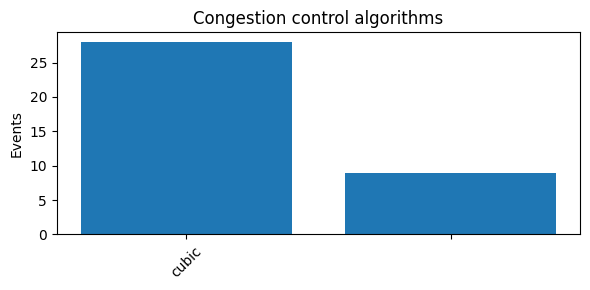


[5] CROSS-HOOK ANALYSIS
----------------------------------------
Overall Health Score: 61.50268336314848/100
Issues Found:
  • Packet drops: 0.85%
  • High backlog: 16.3%
  • Connection failures: 900.0%

Recommendations:
  • Increase socket buffer: sysctl -w net.core.rmem_max=134217728
  • Check network interface: ethtool -S <interface>
  • Review firewall rules: iptables -L -n -v


In [9]:
iperf_data = analyze_tcp_hooks(data, "iperf3")

In [ ]:
# Create collector with XSBench configuration
collect = Collector("./config/xsbench.yaml")

# Start collection and run XSBench
print("Starting collection with XSBench workload...")
collect.start_collection(None)

# Wait for XSBench to complete
print("Running XSBench benchmark...")
data = collect.stop_collection()




In [ ]:
xsbench_data = analyze_tcp_hooks(data, "XSBench")

In [ ]:
collect = Collector("./config/redis_never.yaml")
collect.start_collection(None)
data = collect.stop_collection()

In [ ]:
redis_data = analyze_tcp_hooks(data, "Redis")